# Adult Census Dataset - Fairness Analysis

This notebook evaluates fairness vs information retention trade-offs on the UCI Adult Census dataset.

**Dataset**: Adult Census Income (~48,000 samples)

**Sensitive Attribute**: Sex (Male vs Female)

**Task**: Predict income >$50K

In [15]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

from datasets import load_adult_census, get_dataset_summary
from fairness_metrics import compute_all_fairness_metrics, compute_performance_metrics
from preprocessing import Reweighing, DisparateImpactRemover, LabelFlipping, SamplingStrategy
from inprocessing import FairnessRegularizedClassifier, AdversarialDebiasing, ConstrainedClassifier
from postprocessing import EqualizedOddsPostProcessor, ThresholdOptimizer, CalibratedPostProcessor, RejectOptionClassifier
from visualization import plot_accuracy_fairness_tradeoff, plot_pareto_frontier, create_summary_dashboard

print("Modules loaded!")

Modules loaded!


## 1. Data Loading

In [16]:
data = load_adult_census(sensitive_attr='sex', random_state=42)
display(get_dataset_summary(data))

X_train, X_test = data['X_train'], data['X_test']
y_train, y_test = data['y_train'], data['y_test']
sens_train, sens_test = data['sensitive_train'], data['sensitive_test']

print(f"Training: {len(X_train)}, Test: {len(X_test)}, Features: {X_train.shape[1]}")

,Dataset,Task,N Train,N Test,N Features,Positive Rate (Train),Sensitive Attr,Group 0 Rate,Group 1 Rate,Group 0 Pos Rate,Group 1 Pos Rate,Disparate Impact
0,Adult Census,Income prediction,21113,9049,14,24.89%,sex,32.57%,67.43%,11.12%,31.55%,0.353


Training: 21113, Test: 9049, Features: 14


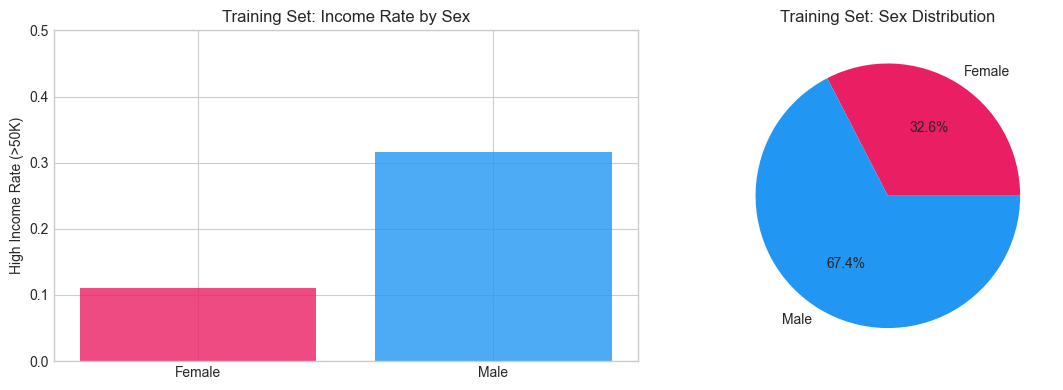

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
for g, label in data['metadata']['sensitive_groups'].items():
    mask = sens_train == g
    pos_rate = y_train[mask].mean()
    ax.bar(label, pos_rate, color=['#E91E63', '#2196F3'][g], alpha=0.8)
ax.set_ylabel('High Income Rate (>50K)')
ax.set_title('Training Set: Income Rate by Sex')
ax.set_ylim(0, 0.5)

ax = axes[1]
sizes = [np.sum(sens_train == g) for g in data['metadata']['sensitive_groups'].keys()]
labels = list(data['metadata']['sensitive_groups'].values())
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#E91E63', '#2196F3'])
ax.set_title('Training Set: Sex Distribution')

plt.tight_layout()
plt.show()

## 2. All Methods

In [18]:
results = []

def evaluate_model(y_true, y_pred, y_prob, sensitive, method_name, category):
    perf = compute_performance_metrics(y_true, y_pred, y_prob)
    fair = compute_all_fairness_metrics(y_true, y_pred, y_prob, sensitive)
    return {
        'Method': method_name, 'Category': category,
        'Accuracy': perf['accuracy'], 'AUC': perf.get('auc', np.nan),
        'Precision': perf['precision'], 'Recall': perf['recall'], 'F1': perf['f1'],
        'DPD': fair['demographic_parity_difference'],
        'DPR': fair['demographic_parity_ratio'],
        'EOD': fair['equalized_odds_difference']['average']
    }

In [19]:
# Baseline
baseline_clf = LogisticRegression(max_iter=1000, random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)
y_prob_baseline = baseline_clf.predict_proba(X_test)[:, 1]
results.append(evaluate_model(y_test, y_pred_baseline, y_prob_baseline, sens_test, 'Baseline', 'Baseline'))
print(f"Baseline: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

Baseline: Acc=0.8172, DPD=0.1784


In [20]:
# Pre-processing methods
print("Running pre-processing methods...")

reweigher = Reweighing()
reweigher.fit(X_train, y_train, sens_train)
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train, sample_weight=reweigher.get_weights())
results.append(evaluate_model(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1], sens_test, 'Reweighing', 'Pre-processing'))
print(f"  Reweighing: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

for rl in [0.5, 1.0]:
    dir_proc = DisparateImpactRemover(sensitive_attr_idx=0, repair_level=rl)
    dir_proc.fit(X_train, sensitive=sens_train)
    X_tr = dir_proc.transform(X_train, sens_train)
    X_te = dir_proc.transform(X_test, sens_test)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_tr, y_train)
    results.append(evaluate_model(y_test, clf.predict(X_te), clf.predict_proba(X_te)[:, 1], sens_test, f'DIR (r={rl})', 'Pre-processing'))
    print(f"  DIR (r={rl}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

for strategy in ['targeted', 'equalize']:
    flipper = LabelFlipping(flip_rate=0.1, strategy=strategy)
    flipper.fit(X_train, y_train, sens_train)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, flipper.transform(y_train))
    results.append(evaluate_model(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1], sens_test, f'LabelFlip ({strategy})', 'Pre-processing'))
    print(f"  LabelFlip ({strategy}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

for strategy in ['oversample', 'undersample', 'hybrid']:
    sampler = SamplingStrategy(strategy=strategy)
    X_res, y_res, s_res = sampler.fit_resample(X_train, y_train, sens_train)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_res, y_res)
    results.append(evaluate_model(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1], sens_test, f'Sampling ({strategy})', 'Pre-processing'))
    print(f"  Sampling ({strategy}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

Running pre-processing methods...
  Reweighing: Acc=0.8078, DPD=0.0707
  DIR (r=0.5): Acc=0.8173, DPD=0.1782
  DIR (r=1.0): Acc=0.8106, DPD=0.0891
  LabelFlip (targeted): Acc=0.7878, DPD=0.0185
  LabelFlip (equalize): Acc=0.7883, DPD=0.0161
  Sampling (oversample): Acc=0.7464, DPD=0.1119
  Sampling (undersample): Acc=0.7481, DPD=0.1035
  Sampling (hybrid): Acc=0.7432, DPD=0.1100


In [21]:
# In-processing methods
print("Running in-processing methods...")

for lf in [0.1, 0.5, 1.0, 2.0]:
    clf = FairnessRegularizedClassifier(lambda_fairness=lf, max_iter=500)
    clf.fit(X_train, y_train, sens_train)
    results.append(evaluate_model(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1], sens_test, f'FairReg (λ={lf})', 'In-processing'))
    print(f"  FairReg (λ={lf}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

for aw in [0.5, 1.0]:
    try:
        clf = AdversarialDebiasing(adversary_weight=aw, n_epochs=30, use_pytorch=True)
        clf.fit(X_train, y_train, sens_train)
        results.append(evaluate_model(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1], sens_test, f'Adversarial (w={aw})', 'In-processing'))
        print(f"  Adversarial (w={aw}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")
    except Exception as e:
        print(f"  Adversarial (w={aw}) failed: {e}")

for th in [0.05, 0.1]:
    clf = ConstrainedClassifier(constraint_threshold=th, max_iter=500)
    clf.fit(X_train, y_train, sens_train)
    results.append(evaluate_model(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1], sens_test, f'Constrained (ε={th})', 'In-processing'))
    print(f"  Constrained (ε={th}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

Running in-processing methods...
  FairReg (λ=0.1): Acc=0.7571, DPD=0.0052
  FairReg (λ=0.5): Acc=0.7565, DPD=0.0044
  FairReg (λ=1.0): Acc=0.7562, DPD=0.0039
  FairReg (λ=2.0): Acc=0.7559, DPD=0.0034
  Adversarial (w=0.5): Acc=0.8402, DPD=0.1455
  Adversarial (w=1.0): Acc=0.8325, DPD=0.0963
  Constrained (ε=0.05): Acc=0.8083, DPD=0.3498
  Constrained (ε=0.1): Acc=0.8105, DPD=0.2807


In [22]:
# Post-processing methods
print("Running post-processing methods...")
y_prob_train = baseline_clf.predict_proba(X_train)[:, 1]

eo = EqualizedOddsPostProcessor()
eo.fit(y_train, y_prob_train, sens_train)
results.append(evaluate_model(y_test, eo.transform(y_prob_baseline, sens_test), y_prob_baseline, sens_test, 'Equalized Odds', 'Post-processing'))
print(f"  Equalized Odds: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

for fw in [0.3, 0.5, 0.7]:
    to = ThresholdOptimizer(fairness_weight=fw)
    to.fit(y_train, y_prob_train, sens_train)
    results.append(evaluate_model(y_test, to.transform(y_prob_baseline, sens_test), y_prob_baseline, sens_test, f'ThreshOpt (w={fw})', 'Post-processing'))
    print(f"  ThreshOpt (w={fw}): Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

cal = CalibratedPostProcessor(n_bins=10)
cal.fit(y_train, y_prob_train, sens_train)
y_prob_cal = cal.transform(y_prob_baseline, sens_test)
results.append(evaluate_model(y_test, (y_prob_cal >= 0.5).astype(int), y_prob_cal, sens_test, 'Calibrated', 'Post-processing'))
print(f"  Calibrated: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

priv = 1 if y_train[sens_train == 1].mean() > y_train[sens_train == 0].mean() else 0
ro = RejectOptionClassifier(privileged_group=priv)
ro.fit(y_train, y_prob_train, sens_train)
results.append(evaluate_model(y_test, ro.transform(y_prob_baseline, sens_test), y_prob_baseline, sens_test, 'Reject Option', 'Post-processing'))
print(f"  Reject Option: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

Running post-processing methods...
  Equalized Odds: Acc=0.7849, DPD=0.0360
  ThreshOpt (w=0.3): Acc=0.8172, DPD=0.1784
  ThreshOpt (w=0.5): Acc=0.8172, DPD=0.1784
  ThreshOpt (w=0.7): Acc=0.8172, DPD=0.1784
  Calibrated: Acc=0.8179, DPD=0.1873
  Reject Option: Acc=0.8011, DPD=0.0024


## 3. Results

In [23]:
results_df = pd.DataFrame(results)
display(results_df.sort_values('Accuracy', ascending=False))

,Method,Category,Accuracy,AUC,Precision,Recall,F1,DPD,DPR,EOD
13,Adversarial (w=0.5),In-processing,0.840203,NaN,0.740453,0.551066,0.631874,0.145531,0.372532,0.063458
14,Adversarial (w=1.0),In-processing,0.832468,NaN,0.724664,0.527087,0.610283,0.096251,0.545800,0.025583
21,Calibrated,Post-processing,0.817880,NaN,0.716643,0.443606,0.547998,0.187342,0.125356,0.196781
2,DIR (r=0.5),Pre-processing,0.817328,NaN,0.711064,0.448046,0.549714,0.178230,0.167268,0.179126
18,ThreshOpt (w=0.3),Post-processing,0.817217,NaN,0.710563,0.448046,0.549564,0.178392,0.167141,0.179244
0,Baseline,Baseline,0.817217,NaN,0.710563,0.448046,0.549564,0.178392,0.167141,0.179244
20,ThreshOpt (w=0.7),Post-processing,0.817217,NaN,0.710563,0.448046,0.549564,0.178392,0.167141,0.179244
19,ThreshOpt (w=0.5),Post-processing,0.817217,NaN,0.710563,0.448046,0.549564,0.178392,0.167141,0.179244
3,DIR (r=1.0),Pre-processing,0.810587,NaN,0.712816,0.400089,0.512514,0.089120,0.470449,0.032077
16,Constrained (ε=0.1),In-processing,0.810476,NaN,0.643968,0.533304,0.583435,0.280733,0.052293,0.346080


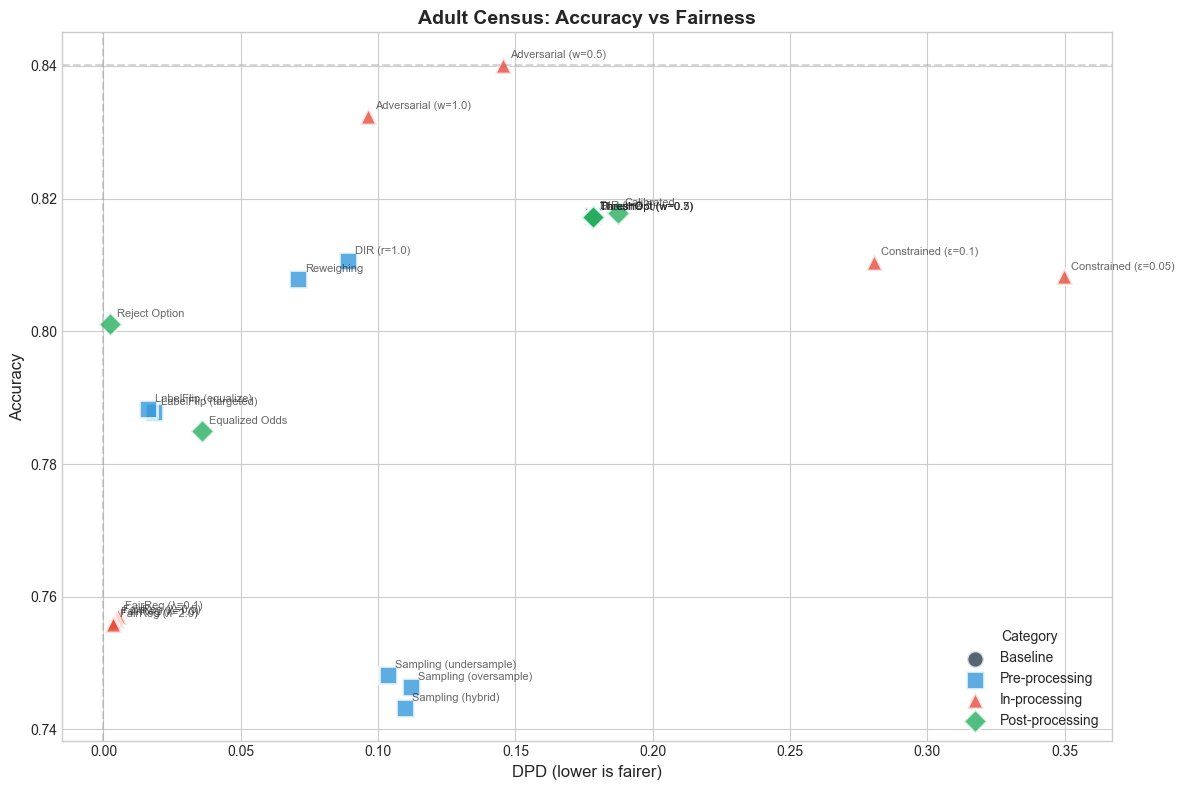

In [24]:
fig = plot_accuracy_fairness_tradeoff(results_df, title='Adult Census: Accuracy vs Fairness')
plt.show()

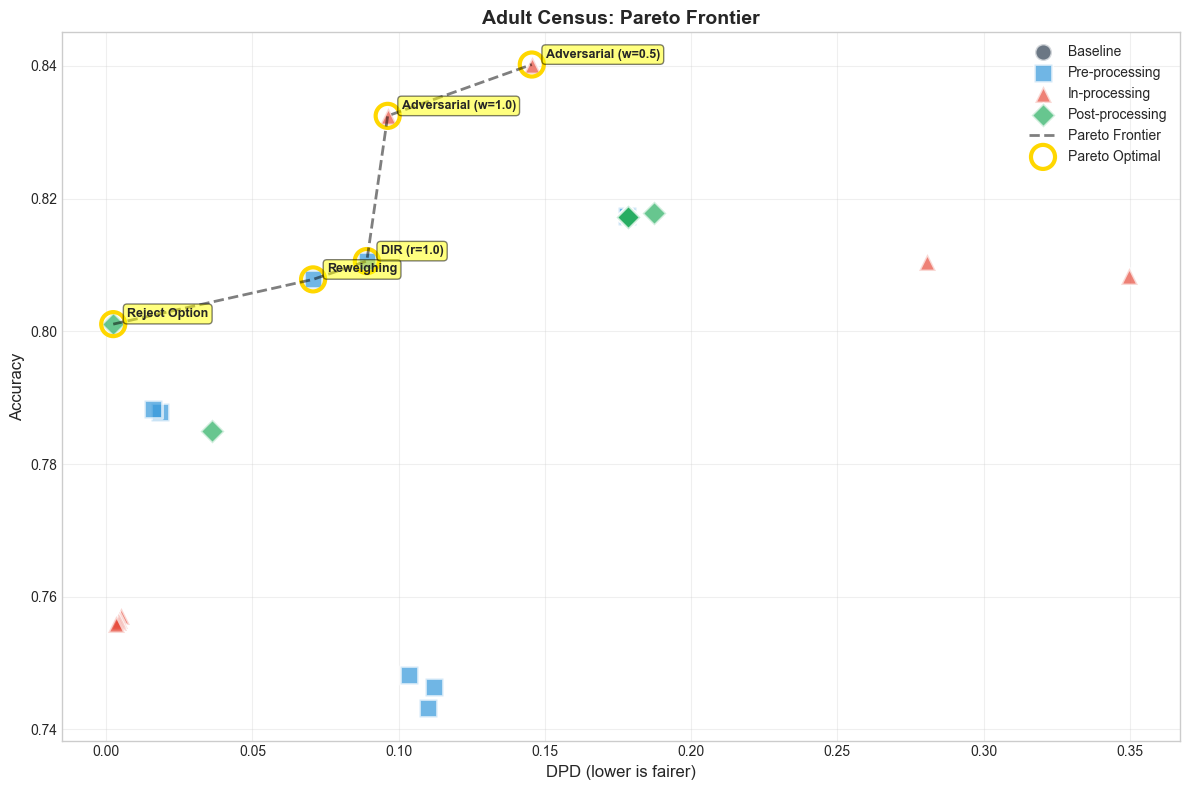

In [25]:
fig = plot_pareto_frontier(results_df, title='Adult Census: Pareto Frontier')
plt.show()

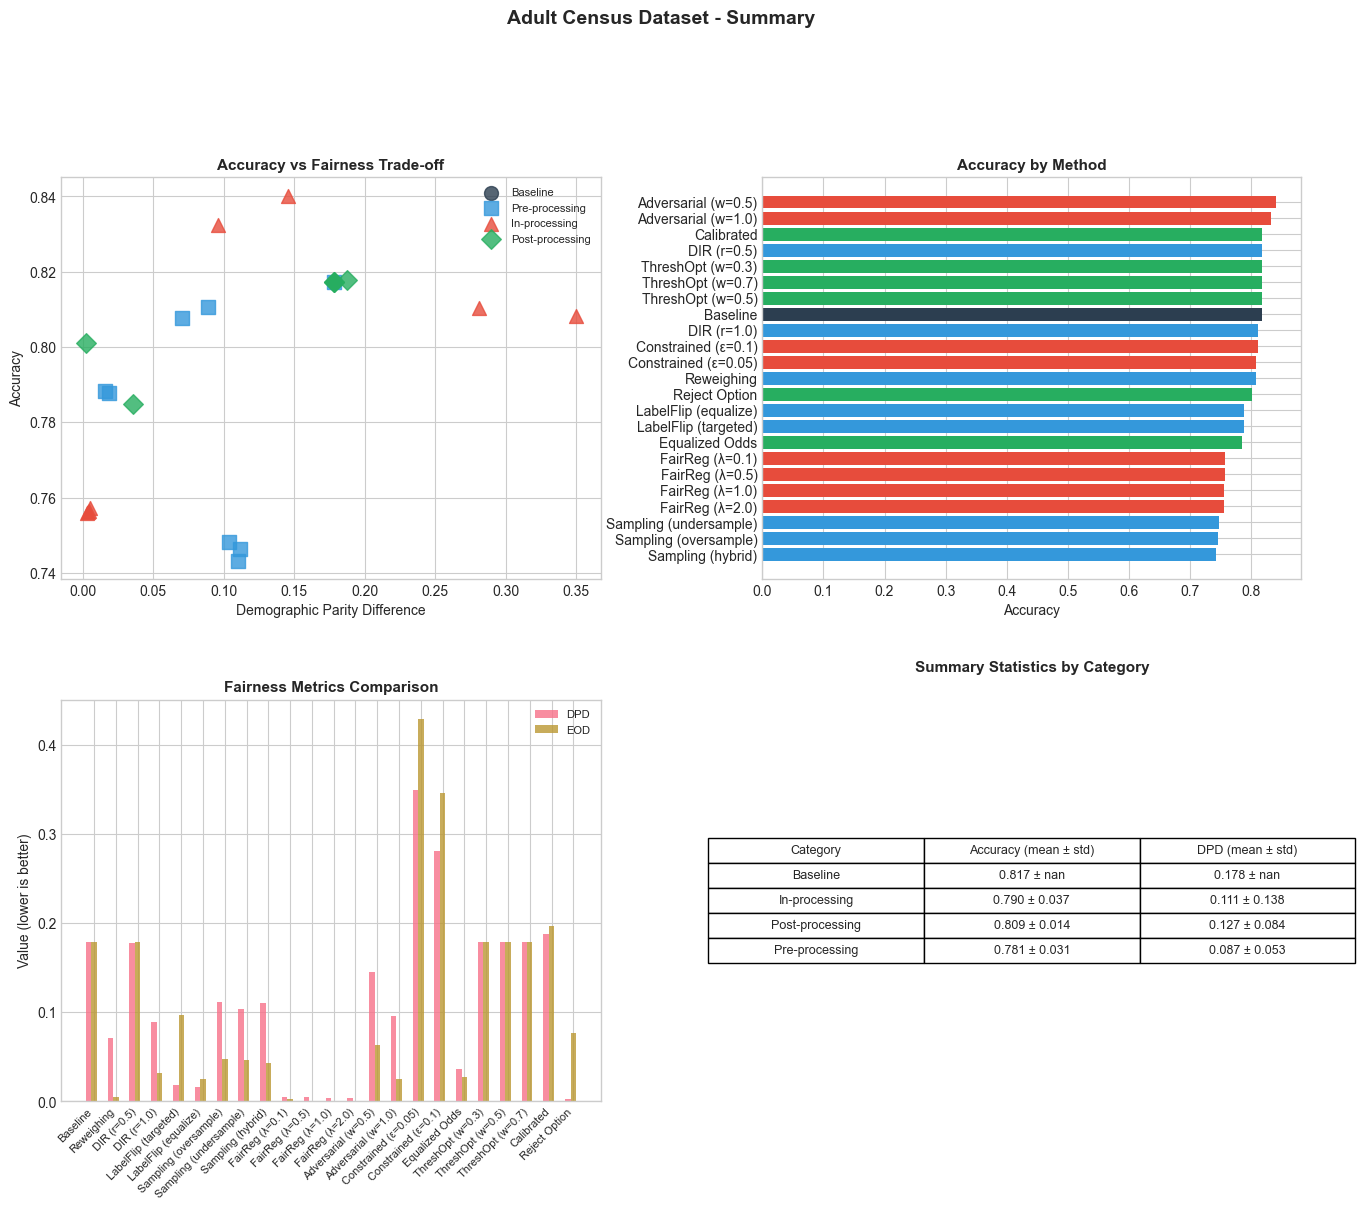

In [26]:
fig = create_summary_dashboard(results_df, title='Adult Census Dataset - Summary')
plt.show()

In [27]:
# Summary statistics
print("\nSUMMARY BY CATEGORY")
print("=" * 50)
display(results_df.groupby('Category').agg({
    'Accuracy': ['mean', 'std', 'max'],
    'DPD': ['mean', 'std', 'min']
}).round(4))


SUMMARY BY CATEGORY


Accuracy                     DPD                
                    mean     std     max    mean     std     min
Category                                                        
Baseline          0.8172     NaN  0.8172  0.1784     NaN  0.1784
In-processing     0.7896  0.0370  0.8402  0.1112  0.1377  0.0034
Post-processing   0.8093  0.0136  0.8179  0.1268  0.0841  0.0024
Pre-processing    0.7812  0.0310  0.8173  0.0873  0.0531  0.0161

In [28]:
results_df.to_csv('../results/adult_census_results.csv', index=False)
print("Results saved!")

Results saved!
